# Introduction to the Mathematics of Deep Learning

**Author:** Mikko Saukkoriipi
**Affiliation:** Aalto University  
**Date:** 2025-09-14  

---

## Deep Learning with Gradient Descent: Height vs. Weight

This notebook explores how to fit simple models to a tiny dataset of **weight → height** using **vanilla gradient descent**.

We train two models:

- **Linear model**

$$
\hat{y} = w x + b
$$

- **Cubic model**

$$
\hat{y} = w_1 x + w_2 x^2 + w_3 x^3 + b
$$

### Training Objective

Both models are trained from scratch with **stochastic gradient descent (SGD)**  
to minimize the **Mean Squared Error (MSE)** loss:

$$
\mathcal{L}_{\text{MSE}} = \frac{1}{N} \sum_{i=1}^{N} \big(\hat{y}_i - y_i\big)^2
$$

### Evaluation Metric

To interpret results in the original units (cm),  
we also compute the **Mean Absolute Error (MAE)**:

$$
\text{MAE} = \frac{1}{N} \sum_{i=1}^{N} \big| \hat{y}_i - y_i \big|
$$

### Outputs

- Predictions for both models  
- Errors per data point  
- Visualizations of the fitting process (loss curves, fitted line/curve)  


In [1]:
# 1) Imports and dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import time

# Create height weight dataset
data = [
    ["Oliver", 58, 150],
    ["George", 59, 157],
    ["Amelia", 62, 163],
    ["Harry", 78, 168],
    ["Isla", 68, 171],
    ["Arthur", 70, 175],
    ["Olivia", 88, 179],
    ["Jack", 89, 182],
    ["Michael", 92, 185],
    ["Charlie", 91, 190],
]

df = pd.DataFrame(data, columns=["name", "weight_kg", "height_cm"])
df


,name,weight_kg,height_cm
0,Oliver,58,150
1,George,59,157
2,Amelia,62,163
3,Harry,78,168
4,Isla,68,171
5,Arthur,70,175
6,Olivia,88,179
7,Jack,89,182
8,Michael,92,185
9,Charlie,91,190


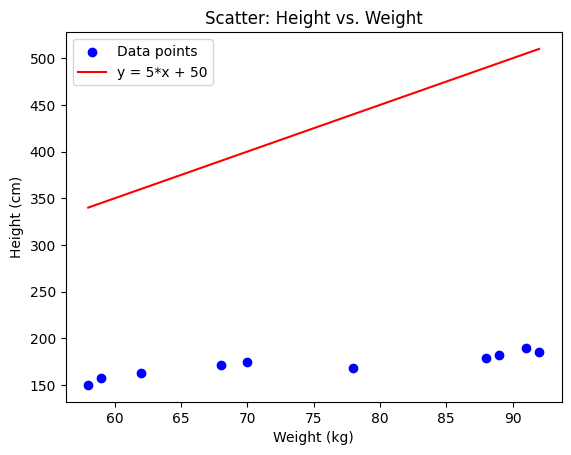

In [2]:
def plot_points_and_line(x_values, y_values, line_expr=None):
    """
    Plot (x, y) data points and optionally a line expression.
    """
    x_values = np.array(x_values).ravel()
    y_values = np.array(y_values).ravel()

    # Plot the raw data points
    plt.scatter(x_values, y_values, color="blue", label="Data points")

    # Plot the optional line expression
    if line_expr:
        x_fit = np.linspace(min(x_values), max(x_values), 200)
        y_fit = eval(line_expr, {"x": x_fit, "np": np})
        plt.plot(x_fit, y_fit, color="red", label=f"y = {line_expr}")

    plt.xlabel("Weight (kg)")
    plt.ylabel("Height (cm)")
    plt.title("Scatter: Height vs. Weight")
    plt.legend()
    plt.show()

plot_points_and_line(
    x_values=df["weight_kg"].values,
    y_values=df["height_cm"].values,
    line_expr="5*x + 50"
)

# Linear Regression with Gradient Descent (Weight → Height)

This notebook fits a **linear regression model** to predict a person’s height from their weight using **stochastic gradient descent (SGD)**.

---

## 1. Model

We assume a **linear relationship** between input $x$ (weight) and output $y$ (height):

$$
\hat{y} = w \, x + b
$$

* $w$: slope (weight → height effect)
* $b$: bias (intercept)
* $\hat{y}$: predicted height

---

## 2. Normalization

Before training, both input $x$ and target $y$ are **z-normalized**:

$$
x_{\text{norm}} = \frac{x - \mu_x}{\sigma_x}, 
\quad 
y_{\text{norm}} = \frac{y - \mu_y}{\sigma_y}
$$

* $\mu$: mean
* $\sigma$: standard deviation

After training, predictions are **inverse-transformed** back to cm.

---

## 3. Loss Function

We train by minimizing the **Mean Squared Error (MSE)**:

$$
\mathcal{L}(w, b) = \frac{1}{N} \sum_{i=1}^{N} \big(\hat{y}_i - y_i\big)^2
$$

where:

* $N$ = number of samples
* $\hat{y}_i$ = model prediction
* $y_i$ = true target (normalized)

---

## 4. Gradient Computation (via Chain Rule)

For a single sample, the loss is:

$$
\ell = (\hat{y} - y)^2
$$

### Step 1. Differentiate loss wrt prediction

$$
\frac{\partial \ell}{\partial \hat{y}} = 2(\hat{y} - y)
$$

### Step 2. Differentiate prediction wrt parameters

* For slope $w$:

$$
\frac{\partial \hat{y}}{\partial w} = x
$$

* For bias $b$:

$$
\frac{\partial \hat{y}}{\partial b} = 1
$$

### Step 3. Apply chain rule

$$
\frac{\partial \ell}{\partial w} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w} = 2(\hat{y}-y) \cdot x
$$

$$
\frac{\partial \ell}{\partial b} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial b} = 2(\hat{y}-y) \cdot 1
$$

---

## 5. Gradient Descent Updates

$$
w \leftarrow w - \eta \cdot 2(\hat{y}-y)x, 
\quad
b \leftarrow b - \eta \cdot 2(\hat{y}-y)
$$

where $\eta$ = learning rate.

---


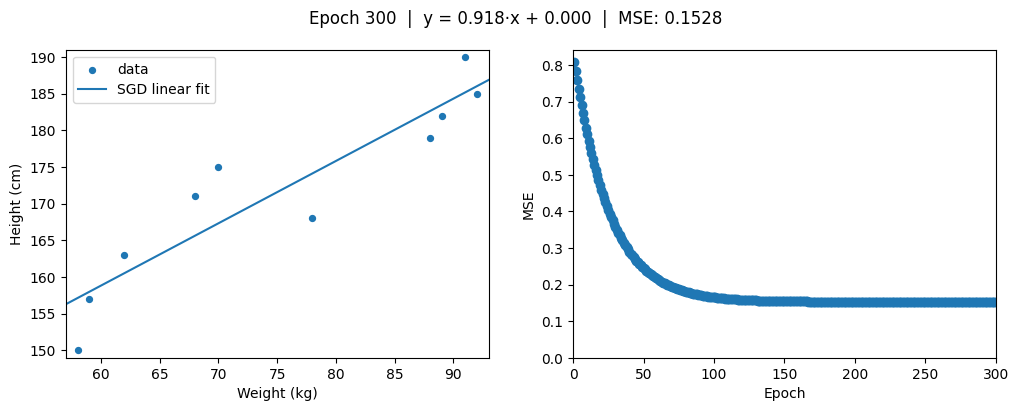

In [3]:
class ZNormalizer:
    """Simple z-score normalizer: (x - mean) / std"""
    def __init__(self):
        self.mean = 0.0
        self.std = 1.0

    def fit(self, x):
        # Store mean/std from training data (tiny epsilon keeps std ≠ 0)
        self.mean = np.mean(x)
        self.std  = np.std(x) + 1e-12
        return self
    
    def transform(self, x):
        # Map raw values to z-space (zero mean, unit variance)
        return (x - self.mean) / self.std
    
    def inverse_transform(self, x_norm):
        # Map predictions from z-space back to original units
        return x_norm * self.std + self.mean


class TrainingPlotter:
    """Utility for plotting training progress: data + linear fit and MSE curve"""
    def __init__(self, x_raw, y_raw, zx, zy, epochs=100):
        self.x, self.y = x_raw, y_raw
        self.zx, self.zy = zx, zy
        self.x_line = np.linspace(x_raw.min()-2, x_raw.max()+2, 300).reshape(-1, 1)
        self.x_line_n = zx.transform(self.x_line)
        self.epochs = epochs

    def show(self, w, b, epoch, mse_history):
        y_line_n = forward_pass(w, b, self.x_line_n)
        y_line   = self.zy.inverse_transform(y_line_n)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Left: data + fit
        ax1.scatter(self.x, self.y, s=18, label="data")
        ax1.plot(self.x_line, y_line, label="SGD linear fit")
        ax1.set_xlabel("Weight (kg)")
        ax1.set_ylabel("Height (cm)")
        ax1.legend()
        ax1.set_xlim(min(self.x)-1, max(self.x)+1)
        ax1.set_ylim(min(self.y)-1, max(self.y)+1)

        # Right: loss curve
        ax2.plot(range(1, len(mse_history)+1), mse_history, marker='o', linewidth=1)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("MSE")
        ax2.set_xlim(0, max(epoch, self.epochs))
        ax2.set_ylim(0, None)

        # Title with equation
        eqn = f"y = {w:.3f}·x + {b:.3f}"
        fig.suptitle(f"Epoch {epoch}  |  {eqn}  |  MSE: {mse_history[-1]:.4f}", fontsize=12)
        
        display(fig)
        plt.close(fig)


def forward_pass(w, b, x):
    """Linear regression: y = w*x + b"""
    return w * x + b


# ---------------- Data ----------------
x = df["weight_kg"].values.reshape(-1, 1)
y = df["height_cm"].values.reshape(-1, 1)
n = x.shape[0]

# ---------------- Z-normalize ----------------
zx = ZNormalizer().fit(x)
zy = ZNormalizer().fit(y)
x_n = zx.transform(x)
y_n = zy.transform(y)

# ---------------- Hyperparameters ----------------
epochs = 300
lr = 0.001

# ---------------- Initialize model parameters ----------------
w = 0.1   # slope
b = 0.1   # bias

# ---------------- Plotter ----------------
plotter = TrainingPlotter(x, y, zx, zy, epochs)

# ---------------- Training (SGD, minibatch=1, MSE) ----------------
mse_history = []

for epoch in range(1, epochs+1):
    clear_output(wait=True)

    # Shuffle training samples
    idx = np.arange(n)
    np.random.shuffle(idx)

    for i in idx:
        xi = float(x_n[i])  # scalar (z-space)
        yi = float(y_n[i])  # target (z-space)

        # ----- Forward pass -----
        yhat = forward_pass(w, b, xi)  # prediction in z-space

        # ----- Gradients via chain rule for MSE -----
        # Loss: ℓ = (ŷ - y)^2
        # Chain rule:
        # dℓ/dŷ = 2*(ŷ - y)
        # dŷ/dw = x (for slope), 1 (for bias)
        # Therefore:
        # dℓ/dw = 2*(ŷ - y) * x
        # dℓ/db = 2*(ŷ - y) * 1
        w -= lr * (2.0 * (yhat - yi) * xi)  # slope update
        b -= lr * (2.0 * (yhat - yi))       # bias update

    # ----- Epoch metric (MSE over full dataset in z-space) -----
    y_hat_epoch = forward_pass(w, b, x_n)
    mse = float(np.mean((y_hat_epoch - y_n) ** 2))
    mse_history.append(mse)

    # ----- Visualize -----
    plotter.show(w, b, epoch, mse_history)
    #time.sleep(0.1)


In [4]:
# Initialize column with NaN
df["predicted_height_cm_linear"] = np.nan
df["error_cm_linear"] = np.nan
for i, row in df.iterrows():
    # normalize input
    x_n = zx.transform([[row["weight_kg"]]])
    y_hat_n = forward_pass(w, b, x_n)
    y_hat = zy.inverse_transform(y_hat_n)
    # store scalar value
    df.at[i, "predicted_height_cm_linear"] = round(y_hat.item(), 1)
    df.at[i, "error_cm_linear"] = df.at[i, "height_cm"] - round(y_hat.item(), 1)
df

,name,weight_kg,height_cm,predicted_height_cm_linear,error_cm_linear
0,Oliver,58,150,157.1,-7.1
1,George,59,157,158.0,-1.0
2,Amelia,62,163,160.5,2.5
3,Harry,78,168,174.1,-6.1
4,Isla,68,171,165.6,5.4
5,Arthur,70,175,167.3,7.7
6,Olivia,88,179,182.6,-3.6
7,Jack,89,182,183.5,-1.5
8,Michael,92,185,186.0,-1.0
9,Charlie,91,190,185.2,4.8


---

# Cubic Regression with Gradient Descent (Weight → Height)

This notebook fits a **cubic regression model** to predict height from weight using **stochastic gradient descent (SGD)**.

---

## 1. Model

We assume a **cubic relationship** between input $x$ (weight) and output $y$ (height):

$$
\hat{y} = w_1 x + w_2 x^2 + w_3 x^3 + b
$$

* $w_1$: slope (linear term)
* $w_2$: quadratic coefficient
* $w_3$: cubic coefficient
* $b$: bias
* $\hat{y}$: predicted height

---

## 2. Normalization

Both input $x$ and target $y$ are **z-normalized** before training:

$$
x_{\text{norm}} = \frac{x - \mu_x}{\sigma_x}, 
\quad 
y_{\text{norm}} = \frac{y - \mu_y}{\sigma_y}
$$

* $\mu$: mean
* $\sigma$: standard deviation

This improves **training stability**. Predictions are later **inverse-transformed** back to cm.

---

## 3. Loss Function

We minimize the **Mean Squared Error (MSE)**:

$$
\mathcal{L}(w_1, w_2, w_3, b) = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2
$$

where:

* $N$ = number of samples
* $\hat{y}_i$ = model prediction
* $y_i$ = true target (normalized)

The per-sample loss is:

$$
\ell = (\hat{y} - y)^2
$$

---

## 4. Gradient Computation (via Chain Rule)

### Step 1. Differentiate loss wrt prediction

$$
\frac{\partial \ell}{\partial \hat{y}} = 2 (\hat{y} - y)
$$

---

### Step 2. Differentiate prediction wrt parameters

$$
\hat{y} = w_1 x + w_2 x^2 + w_3 x^3 + b
$$

$$
\frac{\partial \hat{y}}{\partial w_1} = x,\quad
\frac{\partial \hat{y}}{\partial w_2} = x^2,\quad
\frac{\partial \hat{y}}{\partial w_3} = x^3,\quad
\frac{\partial \hat{y}}{\partial b} = 1
$$

---

### Step 3. Apply Chain Rule

Using the chain rule:

$$
\frac{\partial \ell}{\partial w_1} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_1} = 2 (\hat{y}-y) \cdot x
$$

$$
\frac{\partial \ell}{\partial w_2} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_2} = 2 (\hat{y}-y) \cdot x^2
$$

$$
\frac{\partial \ell}{\partial w_3} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial w_3} = 2 (\hat{y}-y) \cdot x^3
$$

$$
\frac{\partial \ell}{\partial b} = \frac{\partial \ell}{\partial \hat{y}} \cdot \frac{\partial \hat{y}}{\partial b} = 2 (\hat{y}-y) \cdot 1
$$

---

## 5. Gradient Descent Updates

At each step, the parameters are updated using **SGD**:

$$
w_1 \leftarrow w_1 - \eta \cdot 2 (\hat{y}-y) x
$$

$$
w_2 \leftarrow w_2 - \eta \cdot 2 (\hat{y}-y) x^2
$$

$$
w_3 \leftarrow w_3 - \eta \cdot 2 (\hat{y}-y) x^3
$$

$$
b \leftarrow b - \eta \cdot 2 (\hat{y}-y)
$$

where $\eta$ = learning rate.

---

## 6. Training Loop

1. Shuffle dataset each epoch
2. For each sample $(x_i, y_i)$:

   * Compute $\hat{y}_i = w_1 x_i + w_2 x_i^2 + w_3 x_i^3 + b$
   * Compute gradients using **chain rule**
   * Update $w_1, w_2, w_3, b$ using SGD
3. Record **MSE loss** at the end of each epoch

---

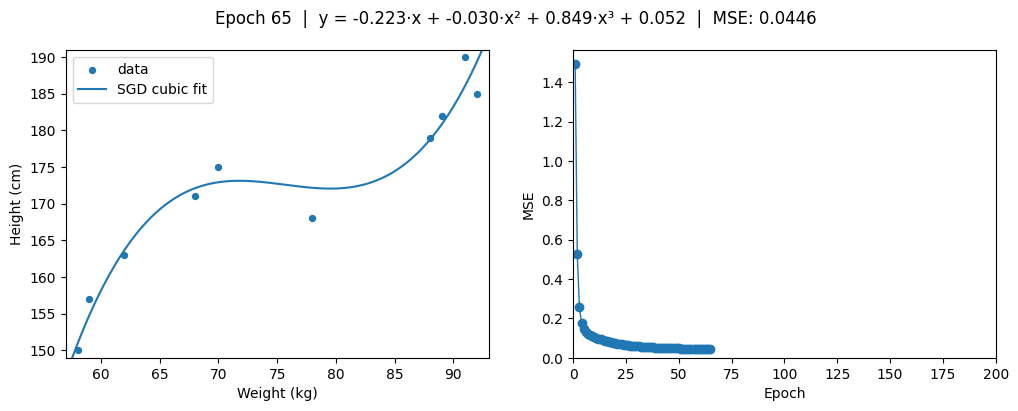

Training stopped at epoch 65 | MSE did not improve (0.044575)


In [5]:
def forward_pass(w1, w2, w3, b, x):
    """
    Cubic regression: ŷ = w1*x + w2*x² + w3*x³ + b
    """
    return w1*x + w2*(x**2) + w3*(x**3) + b

class ZNormalizer:
    """
    Simple z-score normalizer: (x - mean) / std
    """
    def __init__(self):
        self.mean = 0.0
        self.std = 1.0

    def fit(self, x):
        self.mean = np.mean(x)
        self.std  = np.std(x) + 1e-12
        return self
    
    def transform(self, x):
        return (x - self.mean) / self.std
    
    def inverse_transform(self, x_norm):
        return x_norm * self.std + self.mean

class TrainingPlotter:
    """
    Utility class for plotting training progress:
    - Left: raw data + current cubic fit
    - Right: MSE over epochs
    """
    def __init__(self, x_raw, y_raw, zx, zy, epochs=100):
        self.x, self.y, self.zx, self.zy = x_raw, y_raw, zx, zy
        self.x_line = np.linspace(x_raw.min()-2, x_raw.max()+2, 300).reshape(-1, 1)
        self.x_line_n = zx.transform(self.x_line)
        self.epochs = epochs

    def show(self, w1, w2, w3, b, epoch, mse_history):
        # Forward pass for plotting
        y_line_n = forward_pass(w1, w2, w3, b, self.x_line_n)
        y_line = self.zy.inverse_transform(y_line_n)

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

        # Left: data + fit
        ax1.scatter(self.x, self.y, s=18, label="data")
        ax1.plot(self.x_line, y_line, label="SGD cubic fit")
        ax1.set_xlabel("Weight (kg)")
        ax1.set_ylabel("Height (cm)")
        ax1.legend()
        ax1.set_xlim(min(self.x)-1, max(self.x)+1)
        ax1.set_ylim(min(self.y)-1, max(self.y)+1)

        # Right: MSE curve
        ax2.plot(range(1, len(mse_history)+1), mse_history, marker='o', linewidth=1)
        ax2.set_xlabel("Epoch")
        ax2.set_ylabel("MSE")
        ax2.set_xlim(0, max(epoch, self.epochs))
        ax2.set_ylim(0, None)

        eqn = f"y = {w1:.3f}·x + {w2:.3f}·x² + {w3:.3f}·x³ + {b:.3f}"
        fig.suptitle(f"Epoch {epoch}  |  {eqn}  |  MSE: {mse_history[-1]:.4f}", fontsize=12)

        display(fig)
        plt.close(fig)

# ---------------- Data ----------------
x = df["weight_kg"].values.reshape(-1, 1)
y = df["height_cm"].values.reshape(-1, 1)
n = x.shape[0]

# ---------------- Z-normalize ----------------
zx = ZNormalizer().fit(x)
zy = ZNormalizer().fit(y)
x_n = zx.transform(x)
y_n = zy.transform(y)

# ---------------- Hyperparameters ----------------
epochs = 200
lr = 0.01   # typical for z-normalized inputs with MSE

# ---------------- Plotter ----------------
plotter = TrainingPlotter(x, y, zx, zy, epochs)

# ---------------- Initialize model parameters ----------------
w1 = -1
w2 = 0
w3 = 0
b  = 1

# ---------------- Training (SGD, minibatch=1, MSE) ----------------
mse_history = []
prev_mse = float('inf')  # start with very large MSE

epoch = 0
while True:
    epoch += 1
    clear_output(wait=True)

    # Shuffle training samples
    idx = np.arange(n)
    np.random.shuffle(idx)

    for i in idx:
        xi = float(x_n[i])  # scalar (z-space)
        yi = float(y_n[i])  # target

        # ----- Forward pass -----
        yhat = forward_pass(w1, w2, w3, b, xi)

        # ----- Gradients via chain rule for MSE -----
        y_diff = yhat - yi
        w1 -= lr * 2.0 * y_diff * xi
        w2 -= lr * 2.0 * y_diff * (xi**2)
        w3 -= lr * 2.0 * y_diff * (xi**3)
        b  -= lr * 2.0 * y_diff

    # ----- Epoch metric (MSE over full dataset) -----
    y_hat_epoch = forward_pass(w1, w2, w3, b, x_n)
    mse = float(np.mean((y_hat_epoch - y_n) ** 2))
    mse_history.append(mse)

    # ----- Visualize -----
    plotter.show(w1, w2, w3, b, epoch, mse_history)

    # Stop if MSE did not decrease
    if mse >= prev_mse:
        print(f"Training stopped at epoch {epoch} | MSE did not improve ({mse:.6f})")
        break
    prev_mse = mse
    #time.sleep(0.1)

In [6]:
# Initialize column with NaN
df["predicted_height_cm_cubic"] = np.nan
df["error_cm_cubic"] = np.nan
for i, row in df.iterrows():
    # normalize input
    x_n = zx.transform([[row["weight_kg"]]])
    y_hat_n = forward_pass(w1, w2, w3, b, x_n)
    y_hat = zy.inverse_transform(y_hat_n)
    # store scalar value
    df.at[i, "predicted_height_cm_cubic"] = round(y_hat.item(), 1)
    df.at[i, "error_cm_cubic"] = df.at[i, "height_cm"] - round(y_hat.item(), 1)
df


,name,weight_kg,height_cm,predicted_height_cm_linear,error_cm_linear,predicted_height_cm_cubic,error_cm_cubic
0,Oliver,58,150,157.1,-7.1,150.9,-0.9
1,George,59,157,158.0,-1.0,154.8,2.2
2,Amelia,62,163,160.5,2.5,163.7,-0.7
3,Harry,78,168,174.1,-6.1,172.2,-4.2
4,Isla,68,171,165.6,5.4,172.1,-1.1
5,Arthur,70,175,167.3,7.7,172.9,2.1
6,Olivia,88,179,182.6,-3.6,178.7,0.3
7,Jack,89,182,183.5,-1.5,180.8,1.2
8,Michael,92,185,186.0,-1.0,189.3,-4.3
9,Charlie,91,190,185.2,4.8,186.1,3.9
